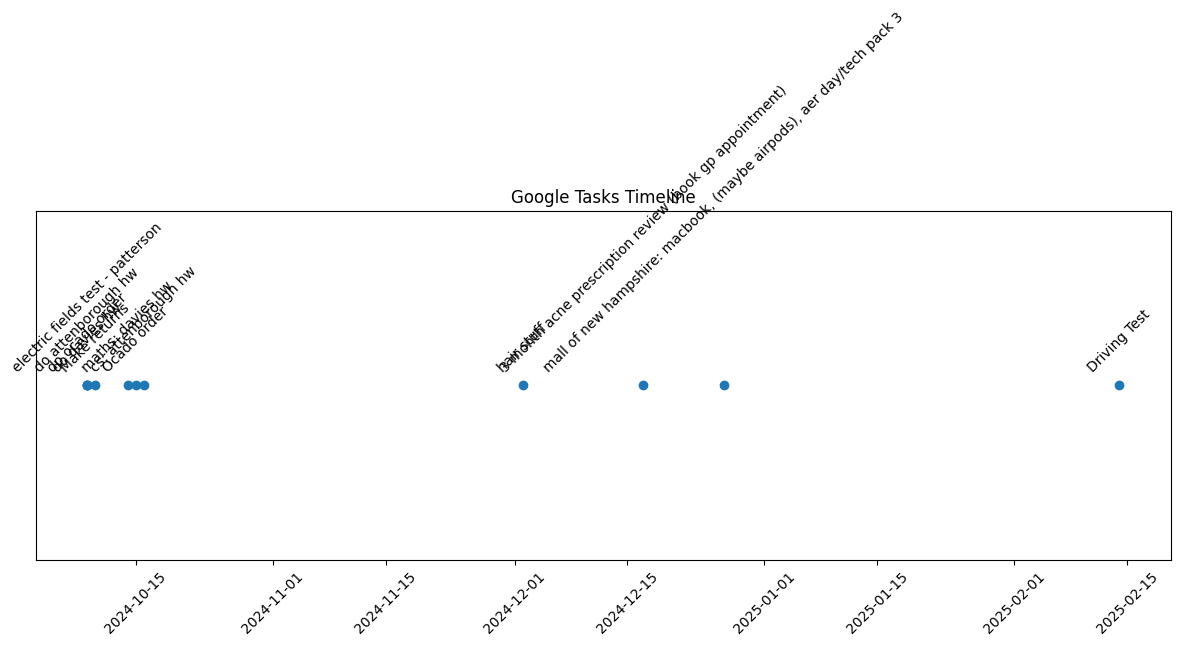

In [3]:
from __future__ import print_function
from datetime import datetime
import os.path
import pickle
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/tasks.readonly']

def main():
    """Retrieves tasks from Google Tasks and visualizes them."""
    creds = None
    # The file token.pickle stores the user's access and refresh tokens.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If no valid credentials are available, prompt the user to log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # Ensure you have the 'credentials.json' file in your directory.
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for future runs.
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('tasks', 'v1', credentials=creds)

    # Retrieve all task lists.
    results = service.tasklists().list(maxResults=100).execute()
    tasklists = results.get('items', [])

    if not tasklists:
        print('No task lists found.')
        return

    all_tasks = []

    # Iterate over each task list and retrieve tasks.
    for tasklist in tasklists:
        tasks_result = service.tasks().list(tasklist=tasklist['id']).execute()
        tasks = tasks_result.get('items', [])
        for task in tasks:
            title = task.get('title', 'No Title')
            due = task.get('due', None)
            status = task.get('status', 'needsAction')
            if due:
                due_datetime = parse(due)
            else:
                due_datetime = None
            all_tasks.append({'title': title, 'due': due_datetime, 'status': status})

    # Visualize the tasks.
    visualize_tasks(all_tasks)

def visualize_tasks(tasks):
    """Visualizes tasks with due dates using matplotlib."""
    # Filter tasks that have due dates.
    tasks_with_due = [task for task in tasks if task['due'] is not None]
    if not tasks_with_due:
        print('No tasks with due dates to visualize.')
        return

    # Sort tasks by due date.
    tasks_with_due.sort(key=lambda x: x['due'])

    dates = [task['due'] for task in tasks_with_due]
    titles = [task['title'] for task in tasks_with_due]

    # Create a scatter plot of tasks over time.
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, [1]*len(dates), marker='o')

    # Annotate each point with the task title.
    for i, title in enumerate(titles):
        plt.annotate(title, (dates[i], 1),
                     textcoords="offset points", xytext=(0, 10),
                     ha='center', rotation=45)

    # Format the x-axis with date labels.
    ax = plt.gca()
    ax.yaxis.set_visible(False)  # Hide the y-axis.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.title('Google Tasks Timeline')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
